In [1]:
import sys
sys.path.insert(0, "../../python")

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from vsim import plot
from vsim import load
from vsim import analyze
import matplotlib.colors as colors
plt.style.use('notes')
from scipy.optimize import curve_fit
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
c = const.physical_constants['speed of light in vacuum'][0]
e = const.physical_constants['elementary charge'][0]

pathPre = '/home/robert/CU-PWFA/emittance_preservation/simulations/DensityGradient/'

In [2]:
# Calculate the densities and the widths of the simulations
den = 5*np.logspace(14, 16, 15)
print(den)
print(250/den**(0.3)/(1/5e16**(0.3)))

[  5.00000000e+14   6.94747747e+14   9.65348864e+14   1.34134790e+15
   1.86379686e+15   2.58973734e+15   3.59842837e+15   5.00000000e+15
   6.94747747e+15   9.65348864e+15   1.34134790e+16   1.86379686e+16
   2.58973734e+16   3.59842837e+16   5.00000000e+16]
[ 995.26792638  901.74317883  817.00689735  740.23323491  670.67394882
  607.65110835  550.5504875   498.81557874  451.94216924  409.47342674
  370.99544724  336.13322107  304.546978    275.9288758   250.        ]


In [3]:
plasma_den = np.array([5e14, 6.95e14, 9.65e14, 1.34e15, 1.86e15, 2.59e15, 3.6e15, 5e15, 6.95e15, 9.65e15,
                       1.34e16, 1.86e16, 2.59e16, 3.6e16, 5e16])
den_name = np.array(['5e14', '6.95e14', '9.65e14', '1.34e15', '1.86e15', '2.59e15', '3.6e15', '5e15', '6.95e15',
                     '9.65e15', '1.34e16', '1.86e16', '2.59e16', '3.6e16', '5e16'])
gradient = np.zeros(len(plasma_den))

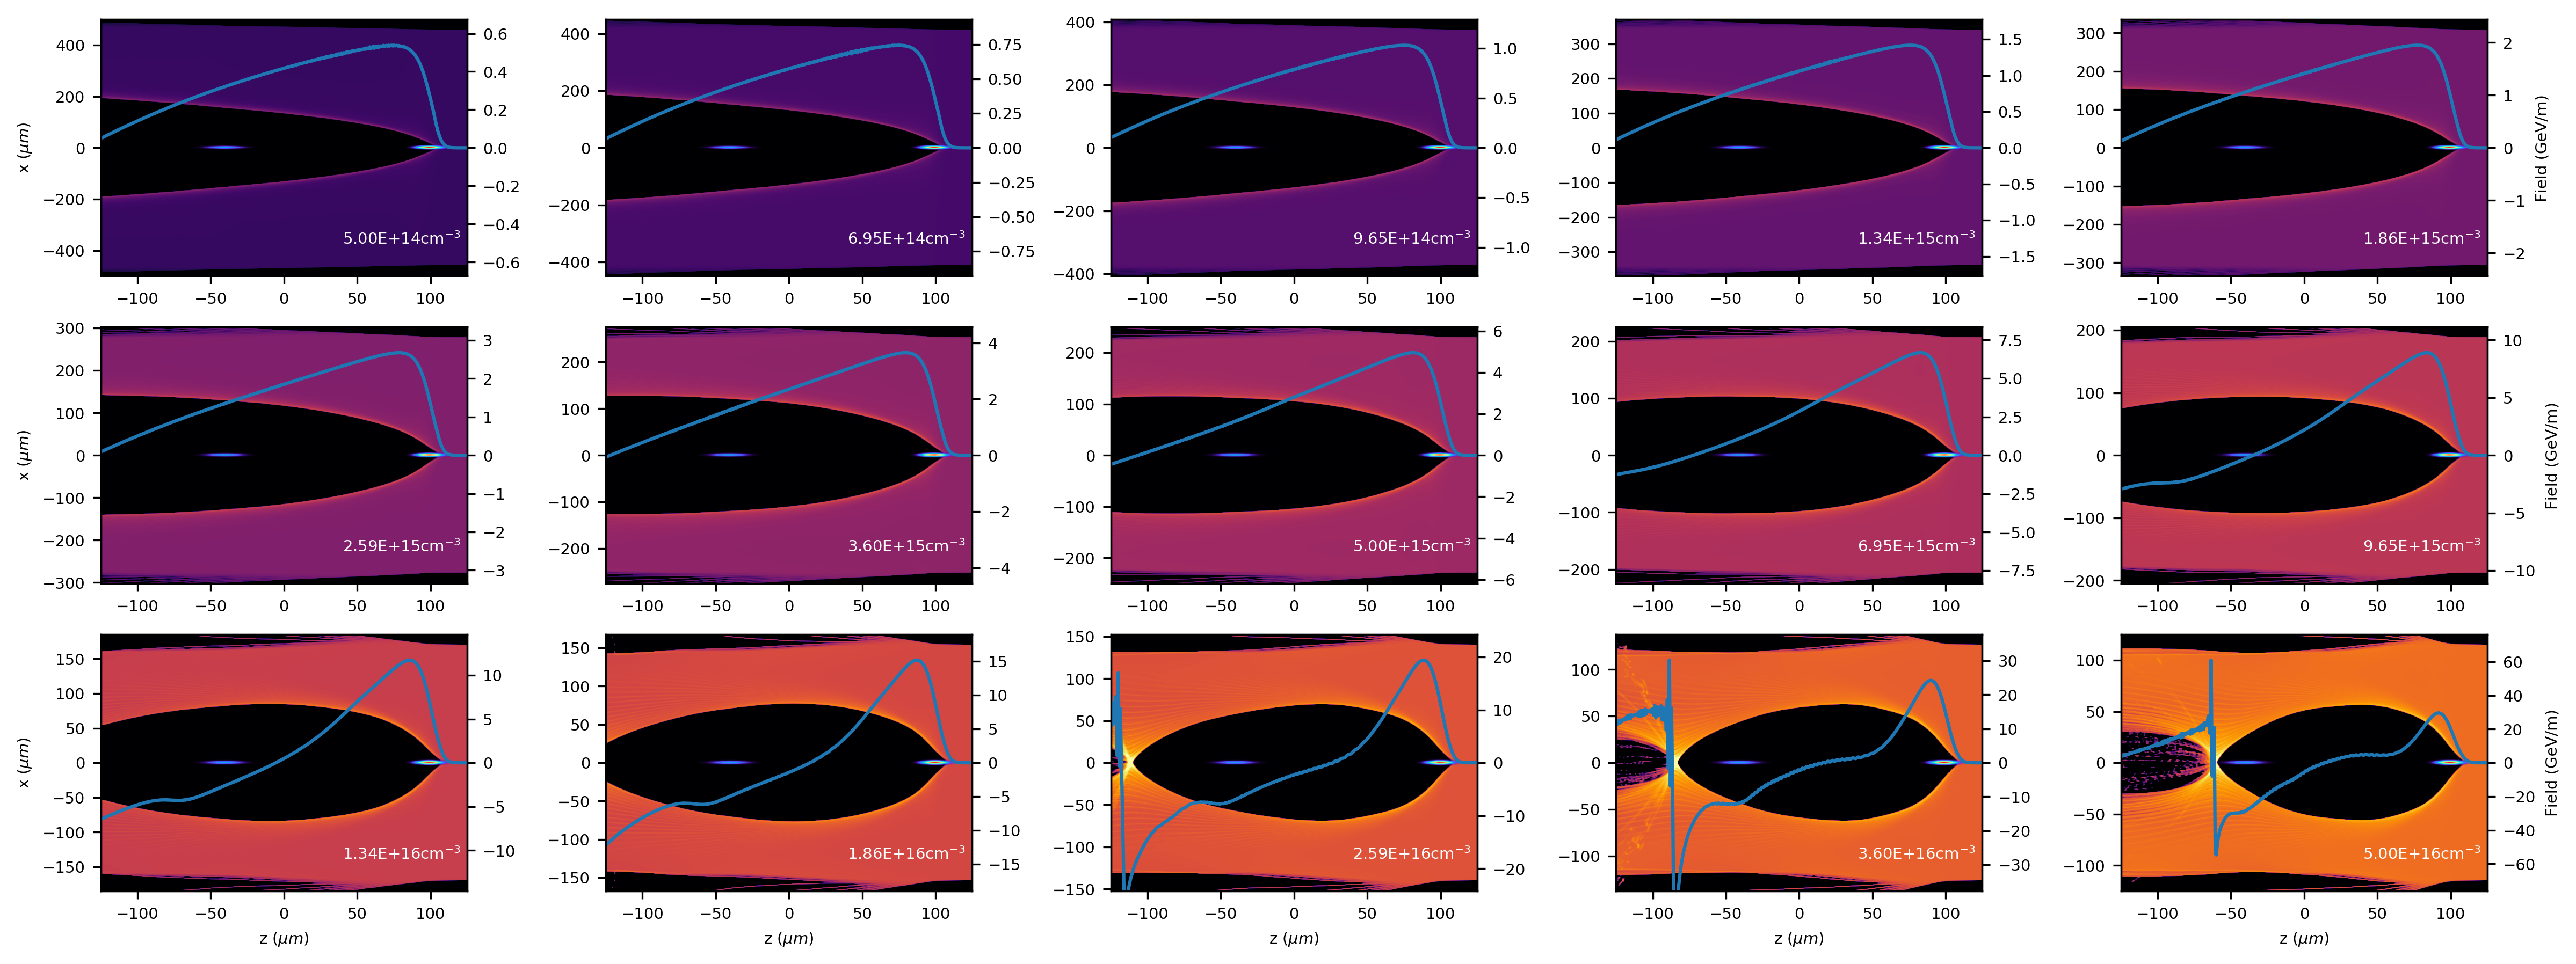

In [4]:
def alpha_colormap(cmap, cutoff, flip=True):
    N = cmap.N
    cmapt = cmap(np.arange(N))
    alpha = np.ones(N)
    if flip:
        temp = alpha[:int(cutoff*N)]
        M = len(temp)
        alpha[:int(cutoff*N)] = np.linspace(0, 1, M)
    else:
        alpha[int((1-cutoff)*N):] = 0.0
    cmapt[:, -1] = alpha
    cmapt = colors.ListedColormap(cmapt)
    return cmapt

plt.figure(figsize=(16,6), dpi=300)
gs = gridspec.GridSpec(3, 5)

for i in range(len(plasma_den)):
    path = pathPre + den_name[i] + 'cm-3/'
    data = np.load(path + 'AcceleratingGradient.npy').item()
    density = np.load(path + 'DensitySlice.npy').item()
    ind = len(density['rhoP'])-1
    rhoXY = -np.transpose(density['rhoP'][ind]/e/1e6)+2 #+2 makes it greater than 0 for log scale
    x = density['xfield']
    y = density['yfield']
        
    #Load in the beam densities
    rhoBXY = -np.transpose(density['rhoB'][ind]/e/1e6)
    xb = (x[-1]-x[0])*1e6/2
    yb = (y[-1]-y[0])*1e6/2
    extent = [-xb, xb, -yb, yb]

    col = i % 5
    row = int(i/5)
    plt.subplot(gs[row, col])
    xplot = np.linspace(-xb, xb, len(x))
    plt.imshow(rhoXY, interpolation='gaussian', aspect='auto', extent=extent,
           norm=colors.LogNorm(vmin=1e14, vmax=1e18), cmap='inferno')
    cmapW = alpha_colormap(plt.cm.get_cmap('rainbow'), 0.1, True)
    plt.imshow(rhoBXY, interpolation='gaussian', aspect='auto', extent=extent, cmap=cmapW)
    if row == 2:
        plt.xlabel(r'z ($\mu m$)')
    if col == 0:
        plt.ylabel(r'x ($\mu m$)')
    plt.text(40, -0.75*yb, r'%0.2E$\mathrm{cm^{-3}}$' % plasma_den[i], color='w')
    plt.twinx()
    plt.plot(xplot, data['field'][6, :]/1e9)
    ymax = np.amax(data['field'][6, :]/1e9)
    plt.ylim(-1.25*ymax, 1.25*ymax)
    if col == 4:
        plt.ylabel(r'Field (GeV/m)')
    plt.xlim(-xb, xb)
plt.tight_layout()
plt.show()

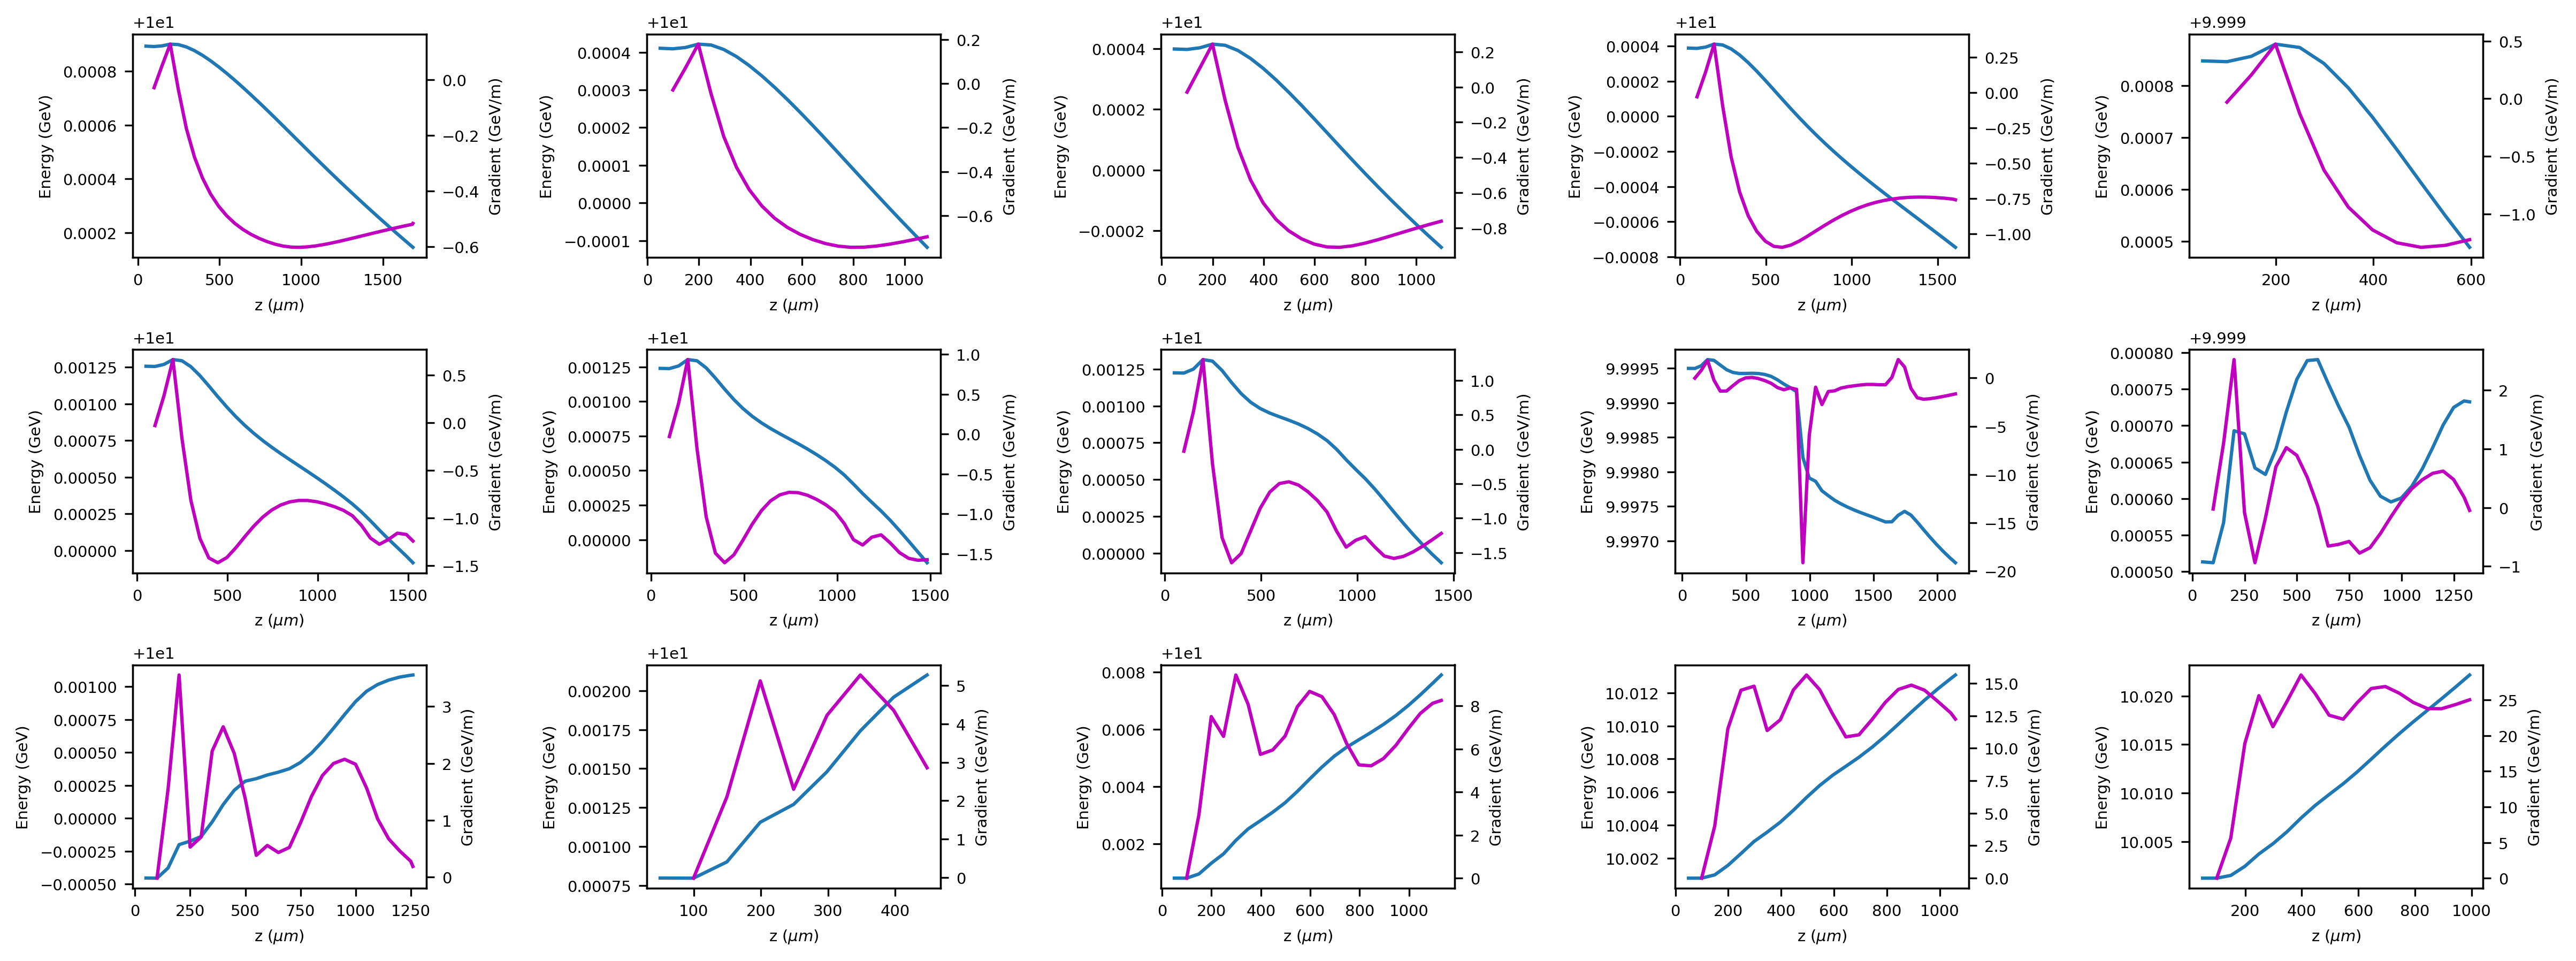

In [5]:
# Plot the energy and gradient
plt.figure(figsize=(16,6), dpi=300)
gs = gridspec.GridSpec(3, 5)

for i in range(len(plasma_den)):
    path = pathPre + den_name[i] + 'cm-3/'
    data = np.load(path + 'AcceleratingGradient.npy').item()
    density = np.load(path + 'DensitySlice.npy').item()
    ind = len(density['rhoP'])-2
    gradient[i] = (data['energy'][ind] - data['energy'][8])/(data['x'][ind] - data['x'][8])
    
    col = i % 5
    row = int(i/5)
    ax1 = plt.subplot(gs[row, col])
    plt.plot(data['x']*1e6, data['energy']/1e3)
    plt.ylabel('Energy (GeV)')
    plt.xlabel(r'z ($\mu m$)')
    plt.twinx()
    plt.plot(data['x'][1:]*1e6, data['gradient']/1e3, 'm')
    plt.ylabel('Gradient (GeV/m)')

plt.tight_layout()
plt.show()
# Something funky happened on the 6.95e15 restart, but the final gradient seems to be correct

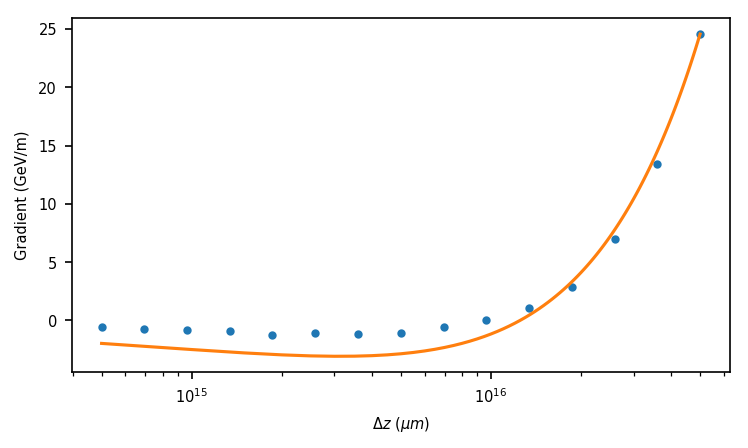

In [6]:
# Use our old model and see how it compares to the newest data
denMod = np.linspace(5e14, 5e16, 100)
ne0 = 5e16
G0  = gradient[-1]
def GAR(ne, G0, ne0):
    return G0*np.sqrt(ne/ne0) * (2*np.sqrt(ne/ne0)-1)

plt.figure(figsize=(5,3), dpi=150)
plt.plot(plasma_den, gradient/1e3, marker='o', markersize=3, linestyle='None')
plt.plot(denMod, GAR(denMod, G0, ne0)/1e3)
plt.ylabel('Gradient (GeV/m)')
plt.xlabel(r'$\Delta z$ ($\mu m$)')
plt.xscale('log')
plt.tight_layout()
plt.show()

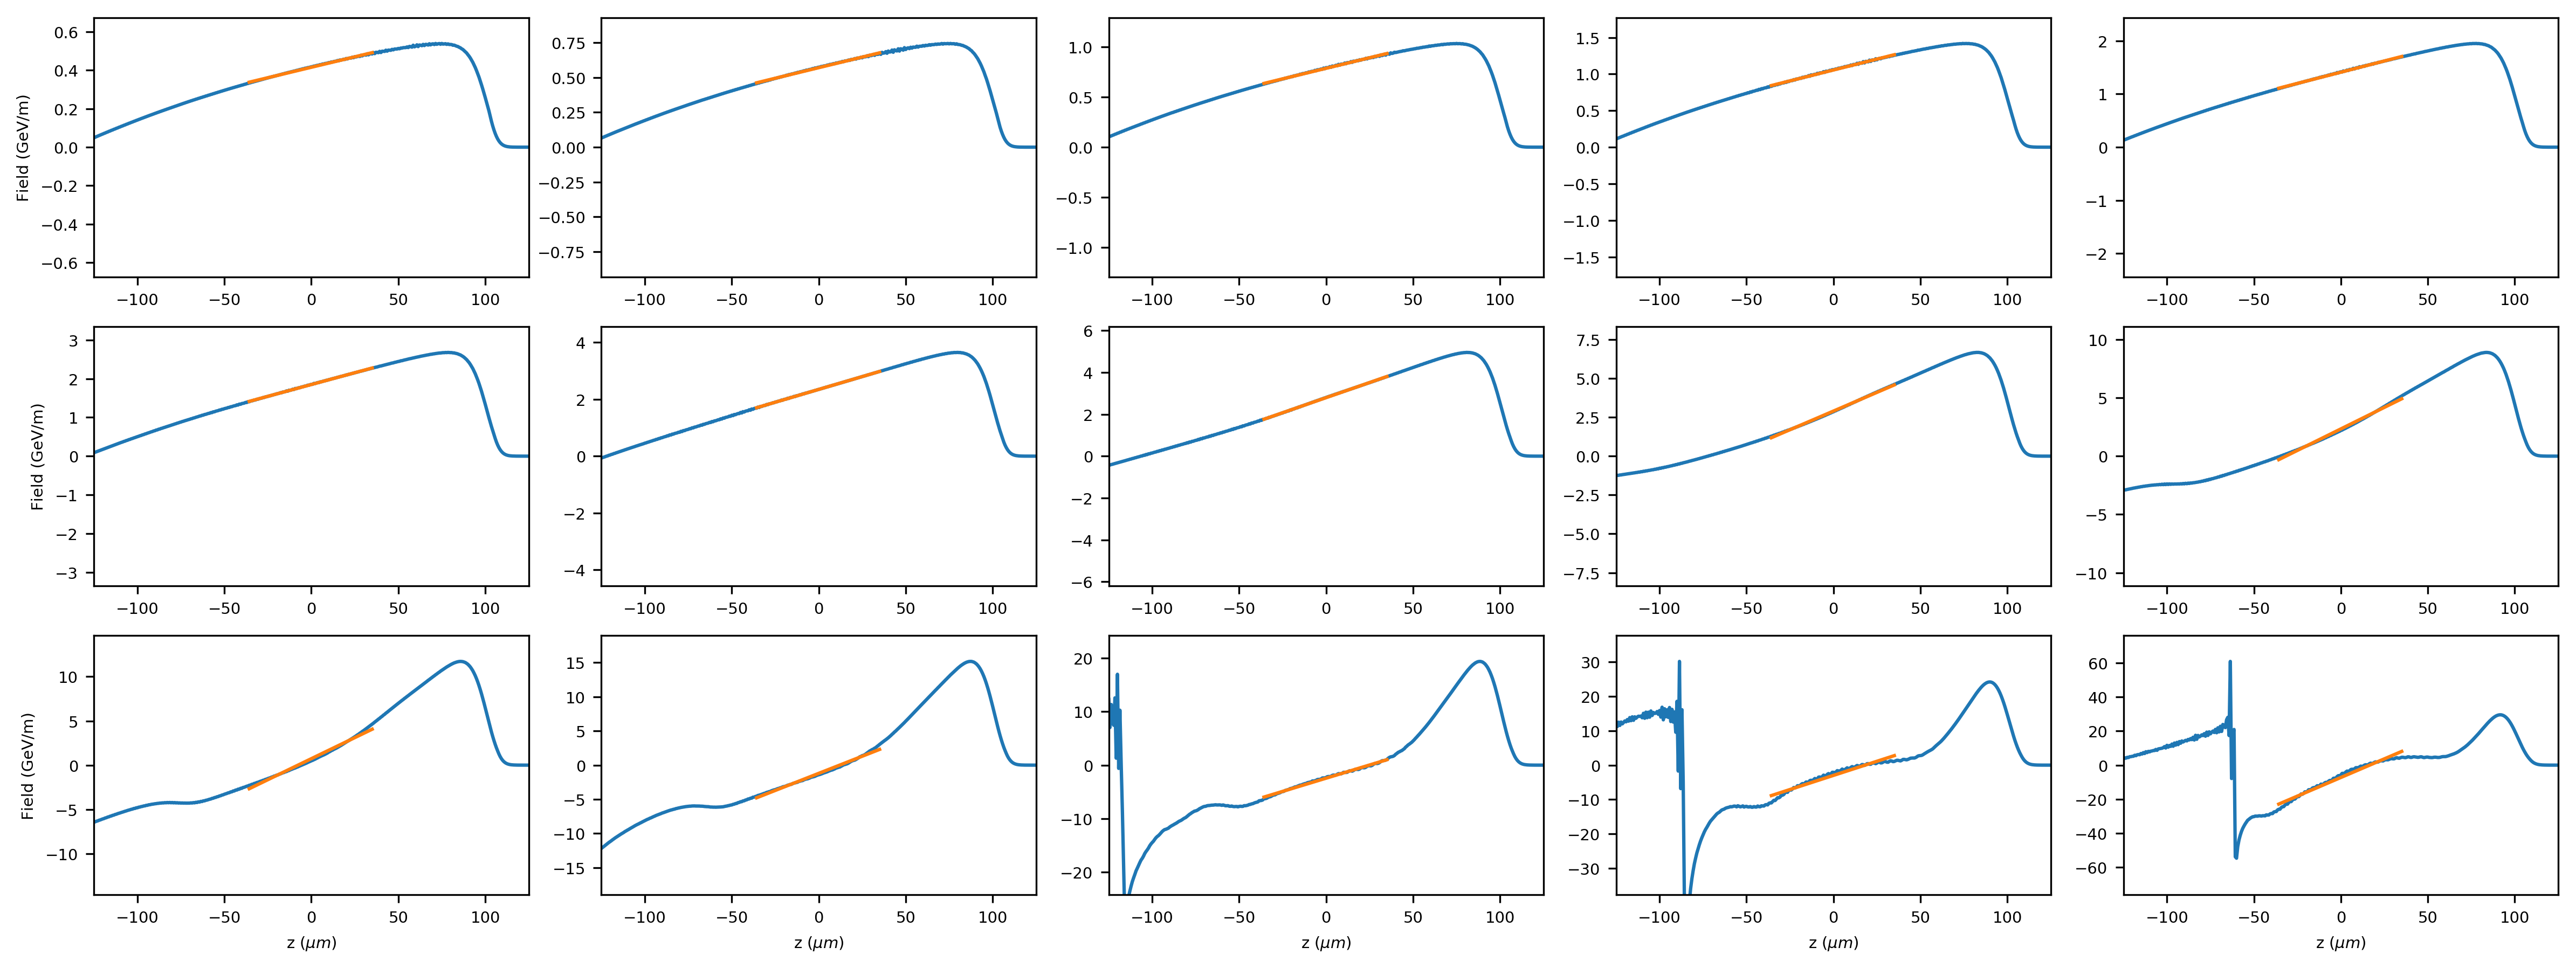

On log-log, slope is 1.09 and intercept is -42.88


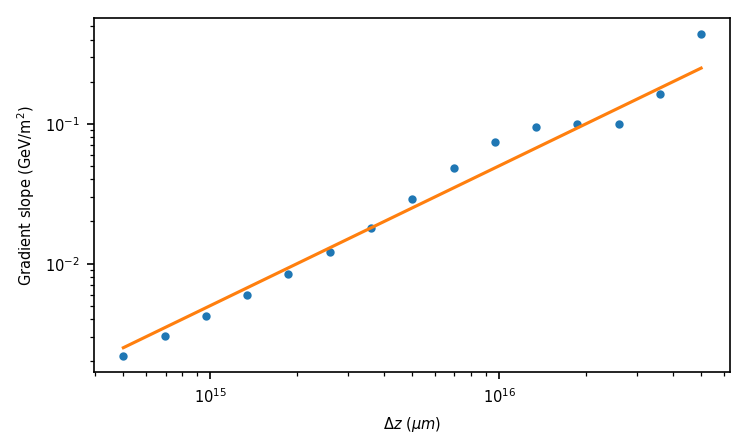

In [7]:
def line(x, m, b):
    return m*x+b

plt.figure(figsize=(16,6), dpi=300)
gs = gridspec.GridSpec(3, 5)
slope = np.zeros(len(plasma_den))
for i in range(len(plasma_den)):
    path = pathPre + den_name[i] + 'cm-3/'
    data = np.load(path + 'AcceleratingGradient.npy').item()
    
    field = data['field'][6, :]/1e9
    x = np.linspace(-125, 125, len(field))
    popt, pcov = curve_fit(line, x[125:225], field[125:225])
    slope[i] = popt[0]
    
    col = i % 5
    row = int(i/5)
    plt.subplot(gs[row, col])
    plt.plot(x, field)
    plt.plot(x[125:225], line(x[125:225], *popt))
    ymax = np.amax(field)
    plt.ylim(-1.25*ymax, 1.25*ymax)
    if row == 2:
        plt.xlabel(r'z ($\mu m$)')
    if col == 0:
        plt.ylabel(r'Field (GeV/m)')
    plt.xlim(-xb, xb)
plt.tight_layout()
plt.show()

# Fit is not working for some reason
popt, pcov = curve_fit(line, np.log(plasma_den), np.log(slope))
print("On log-log, slope is %0.2f and intercept is %0.2f" % (popt[0], popt[1]))

plt.figure(figsize=(5,3), dpi=150)
plt.plot(plasma_den, slope, marker='o', markersize=3, linestyle='None')
plt.plot(denMod, 5e-18*denMod)
plt.ylabel('Gradient slope ($\mathrm{GeV/m^2}$)')
plt.xlabel(r'$\Delta z$ ($\mu m$)')
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()
plt.show()
# As expected, the slope of the accelerating gradient is linear on a log-log plot

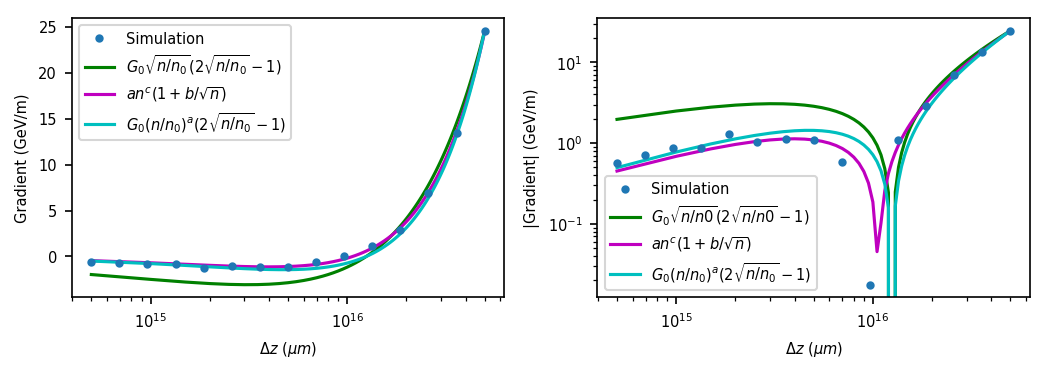

In [8]:
# Slope of the accelerating field is proportional to the plasma density
denMod = np.linspace(5e14, 5e16, 100)
ne0 = 5e16
G0  = gradient[-1]
def GAR(ne, G0, ne0):
    return G0*np.sqrt(ne/ne0) * (2*np.sqrt(ne/ne0)-1)

def func1(ne, a, b, c):
    return a*ne**c*(1+b/np.sqrt(ne))

popt1, pcov = curve_fit(func1, plasma_den[:], gradient[:], p0=[5e-13, -1e8, 1])

def func2(ne, a):
    return G0*(ne/ne0)**a*(2*np.sqrt(ne/ne0) - 1)

popt2, pcov = curve_fit(func2, plasma_den[:], gradient[:])

plt.figure(figsize=(7, 2.5), dpi=150)
gs = gridspec.GridSpec(1, 2)

plt.subplot(gs[0, 0])
plt.plot(plasma_den, gradient/1e3, marker='o', markersize=3, linestyle='None', zorder=100, label='Simulation')
plt.plot(denMod, GAR(denMod, G0, ne0)/1e3, 'g', label=r'$G_0\sqrt{n/n_0}(2\sqrt{n/n_0}-1)$')
plt.plot(denMod, func1(denMod, *popt1)/1e3, 'm', label=r'$an^c(1+b/\sqrt{n})$')
plt.plot(denMod, func2(denMod, *popt2)/1e3, 'c', label=r'$G_0(n/n_0)^a(2\sqrt{n/n_0}-1)$')
plt.ylabel('Gradient (GeV/m)')
plt.xlabel(r'$\Delta z$ ($\mu m$)')
plt.xscale('log')
plt.legend()

plt.subplot(gs[0, 1])
plt.plot(plasma_den, abs(gradient)/1e3, marker='o', markersize=3, linestyle='None', zorder=100, label='Simulation')
plt.plot(denMod, abs(GAR(denMod, G0, ne0))/1e3, 'g', label=r'$G_0\sqrt{n/n0}(2\sqrt{n/n0}-1)$')
plt.plot(denMod, abs(func1(denMod, *popt1))/1e3, 'm', label=r'$an^c(1+b/\sqrt{n})$')
plt.plot(denMod, abs(func2(denMod, *popt2))/1e3, 'c', label=r'$G_0(n/n_0)^a(2\sqrt{n/n_0}-1)$')
plt.ylabel('|Gradient| (GeV/m)')
plt.xlabel(r'$\Delta z$ ($\mu m$)')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

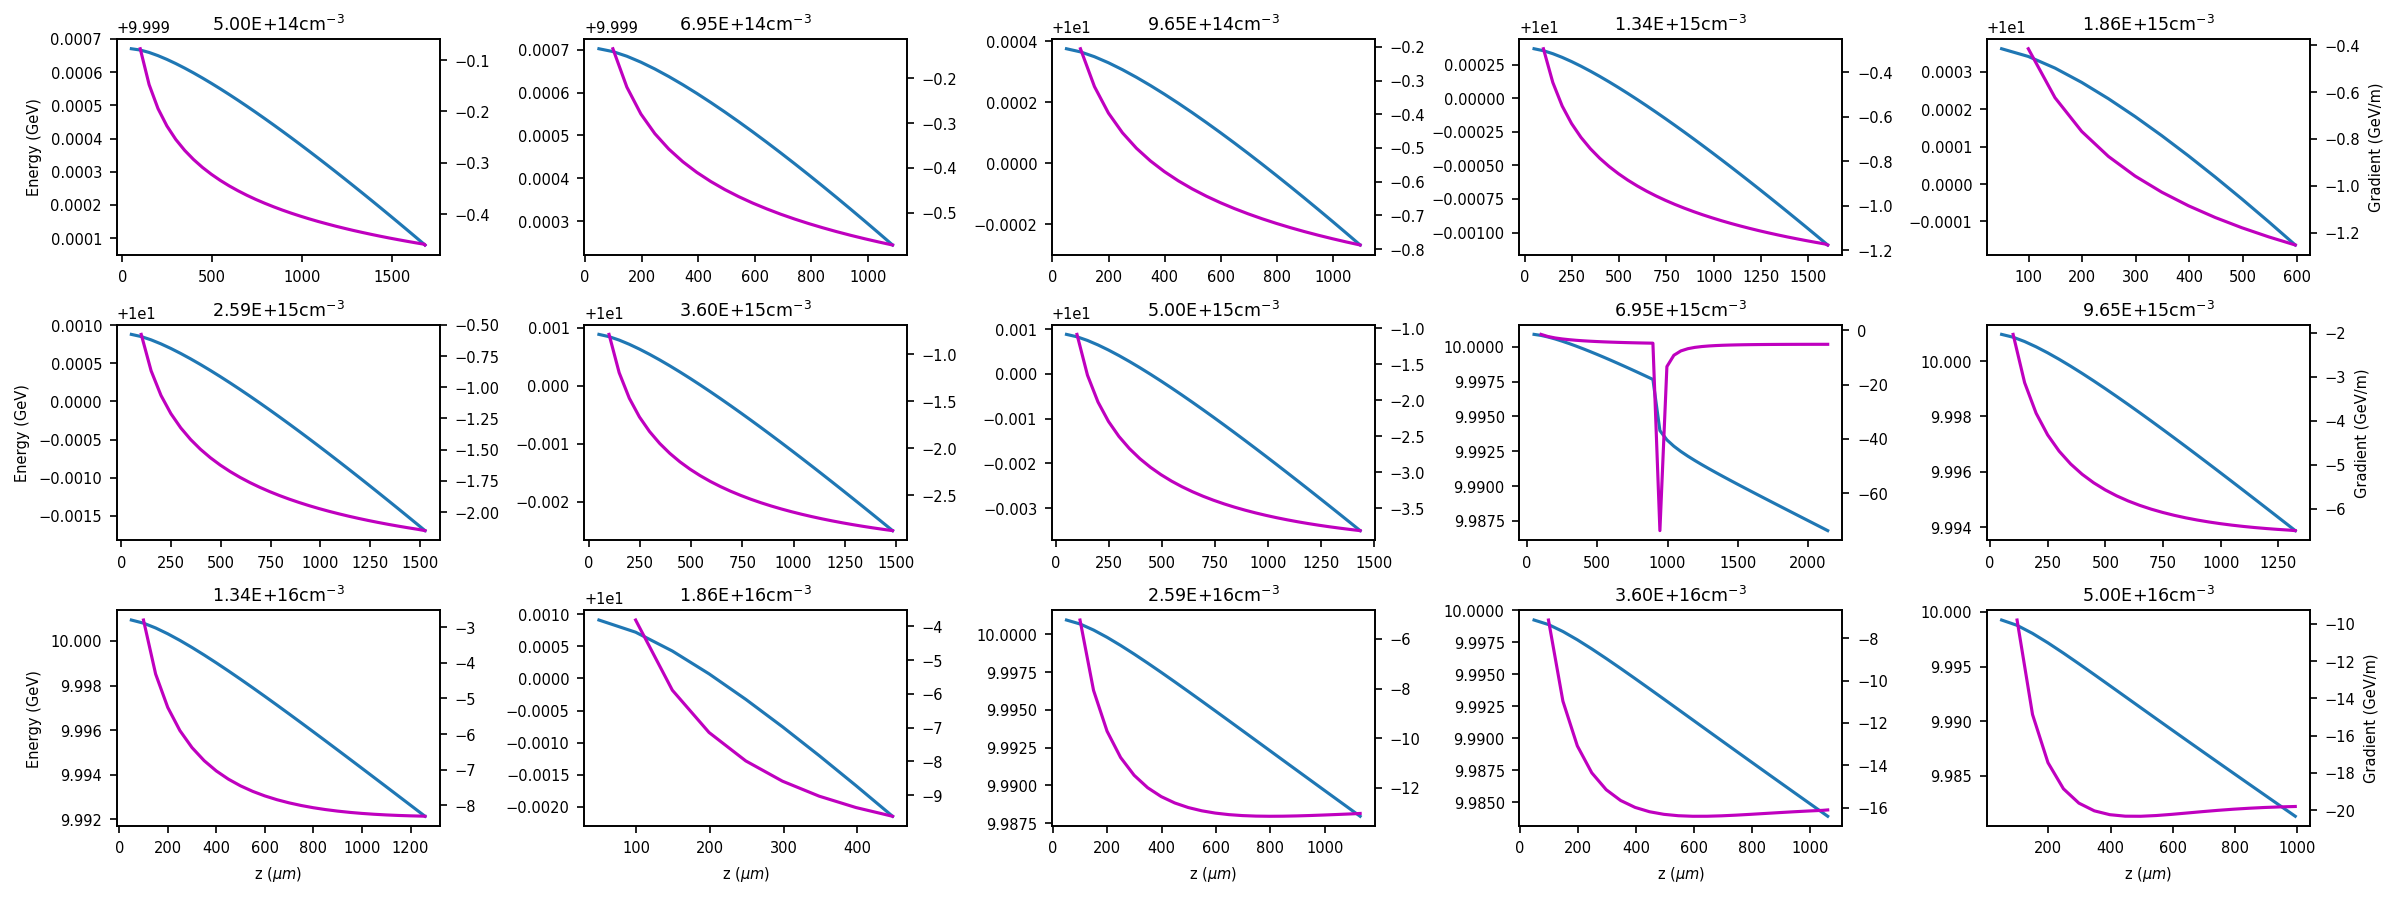

In [9]:
# Plot the energy and gradient
plt.figure(figsize=(16,6), dpi=150)
gs = gridspec.GridSpec(3, 5)

for i in range(len(plasma_den)):
    path = pathPre + den_name[i] + 'cm-3/'
    data = np.load(path + 'DecceleratingGradient.npy').item()
    density = np.load(path + 'DensitySlice.npy').item()
    ind = len(density['rhoP'])-2
    gradient[i] = data['gradient'][-1]
    
    col = i % 5
    row = int(i/5)
    ax1 = plt.subplot(gs[row, col])
    plt.plot(data['x']*1e6, data['energy']/1e3)
    if col==0:
        plt.ylabel('Energy (GeV)')
    if row==2:
        plt.xlabel(r'z ($\mu m$)')
    plt.twinx()
    plt.plot(data['x'][1:]*1e6, data['gradient']/1e3, 'm')
    if col==4:
        plt.ylabel('Gradient (GeV/m)')
    plt.title(r'%0.2E$\mathrm{cm^{-3}}$' % plasma_den[i])

plt.tight_layout()
plt.show()
# Something funky happened on the 6.95e15 restart, but the final gradient seems to be correct

On log-log, slope is 0.84 and intercept is -22.21
Power exponent is 0.71


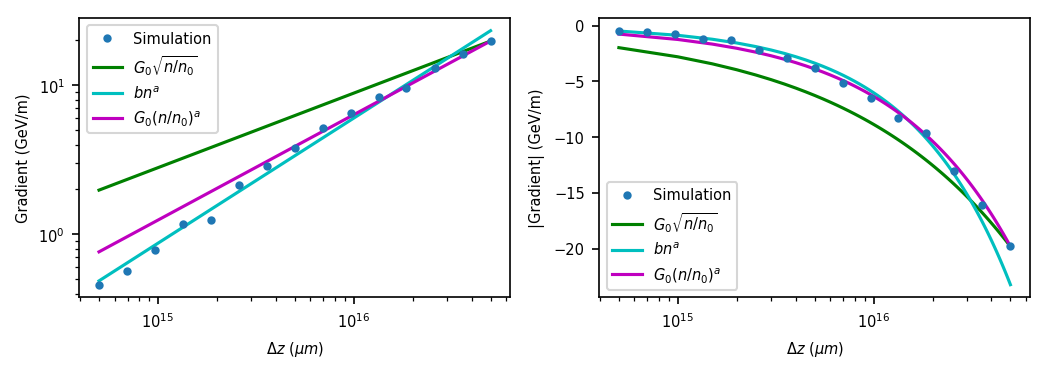

In [10]:
# Use our old model and see how it compares to the newest data
denMod = np.linspace(5e14, 5e16, 100)
ne0 = 5e16
G0  = gradient[-1]
def GAR(ne, G0, ne0):
    return G0*np.sqrt(ne/ne0)

popt, pcov = curve_fit(line, np.log(plasma_den), np.log(-gradient))
print("On log-log, slope is %0.2f and intercept is %0.2f" % (popt[0], popt[1]))

def power(n, a):
    return G0*(n/n0)**a
G0 = gradient[-1]
n0 = plasma_den[-1]
popt2, pcov = curve_fit(power, plasma_den, gradient)
print("Power exponent is %0.2f" % (popt2[0]))

plt.figure(figsize=(7,2.5), dpi=150)
plt.subplot(121)
plt.plot(plasma_den, -gradient/1e3, marker='o', markersize=3, linestyle='None', label='Simulation', zorder=100)
plt.plot(denMod, -GAR(denMod, G0, ne0)/1e3, 'g', label=r'$G_0\sqrt{n/n_0}$')
plt.plot(denMod, np.exp(popt[1])*denMod**popt[0]/1e3, 'c', label=r'$bn^a$')
plt.plot(denMod, -power(denMod, *popt2)/1e3, 'm', label=r'$G_0(n/n_0)^a$')
plt.ylabel('Gradient (GeV/m)')
plt.xlabel(r'$\Delta z$ ($\mu m$)')
plt.legend()
plt.xscale('log')
plt.yscale('log')

plt.subplot(122)
plt.plot(plasma_den, gradient/1e3, marker='o', markersize=3, linestyle='None', label='Simulation', zorder=100)
plt.plot(denMod, GAR(denMod, G0, ne0)/1e3, 'g', label=r'$G_0\sqrt{n/n_0}$')
plt.plot(denMod, -np.exp(popt[1])*denMod**popt[0]/1e3, 'c', label=r'$bn^a$')
plt.plot(denMod, power(denMod, *popt2)/1e3, 'm', label=r'$G_0(n/n_0)^a$')
plt.ylabel('|Gradient| (GeV/m)')
plt.xlabel(r'$\Delta z$ ($\mu m$)')
plt.xscale('log')
plt.legend()
plt.tight_layout()
plt.show()